In [3]:
import glob
import sys
from pathlib import Path
sys.path.append(
    str(Path().absolute())
)

from Backbone.DTI_autoencoder import *
# from Utils.train_utils import *
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import shap
import umap

In [ ]:
master_sheet = pd.read_csv('../Dataset/master_sheet.csv')
fa_cols = [col for col in master_sheet.columns if ('_fa1_mean' in col)]
dti_representation = np.load('../Dataset/aggregated_grid.npy', allow_pickle=True)

In [5]:
fa_values = master_sheet[fa_cols]
## Remove _fa1_mean from the column names
fa_values.columns = fa_values.columns.str.replace('_fa1_mean', '')
additional_covariates = master_sheet.iloc[:, -4:-1]
target = (master_sheet['sex']=='Males').astype(int)

In [ ]:
train_subjects = [] ## Empty list to store the subjects

## Get train and test indices
train_idx = master_sheet['Subject'].apply(lambda a: a in train_subjects)
test_idx = ~train_idx

In [7]:
def convert_to_representation(dataframe, representation):
    '''
    Convert the representation to a matrix
    
    Parameters:
    dataframe: pd.DataFrame
        The dataframe containing the values of the representation
    representation: np.array
        The representation of the data

    Returns:
    array: np.array
        The matrix representation of the given dataframe
    '''
    array = np.zeros((representation.shape[0], representation.shape[1]))
    for (i, j), val in np.ndenumerate(representation):
        if val == '':
            array[i, j] = 0
        else:
            array[i, j] = dataframe.loc[val]

    return array

In [8]:
fa_representation = fa_values.apply(lambda x: convert_to_representation(x, dti_representation), axis=1)
fa_representation = np.stack(fa_representation.values)

In [9]:
## Merging X and Y and train-test split
X = fa_representation
# # Generate 105 random values (one for each 9x9 matrix)
# random_values = np.random.rand(X.shape[0])

# # Add each random value to the bottom-right element (index [8, 8]) of each 9x9 matrix
# fa_representation[:, 8, 8] += random_values

## Expand X dimension at -1
X = np.expand_dims(X, axis=-1)
## Permute to n,c,h,w
X = np.transpose(X, (0, 3, 1, 2))
Y = np.array(target)

## Train-test split
X_train = X[train_idx]
Y_train = Y[train_idx]
X_test = X[test_idx]
Y_test = Y[test_idx]

## Convert into dataloaders for pytorch
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(Y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(Y_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [10]:
dti_representation[8,8] = 'Random'

## Training Pipeline

In [11]:
def beta_vae_loss(x, x_recon, mu, logvar, beta=1.0, recon_type="mse", reduction="sum"):
    """
    Computes the β-VAE loss as the sum of a reconstruction loss and a weighted KL divergence.

    Args:
        x (Tensor): Original input [B, C, H, W].
        x_recon (Tensor): Reconstructed output [B, C, H, W].
        mu (Tensor): Mean of q(z|x) [B, latent_dim].
        logvar (Tensor): Log-variance of q(z|x) [B, latent_dim].
        beta (float): Weight for the KL divergence term.
        recon_type (str): "mse" or "bce" for reconstruction loss.
        reduction (str): "sum" or "mean" for final loss.

    Returns:
        total_loss (Tensor): Reconstruction loss + β * KL divergence.
        recon_loss (Tensor): Reconstruction loss.
        kl_loss (Tensor): Weighted KL divergence term (β * KL).
    """
    # 1. Reconstruction Loss
    if recon_type == "bce":
        recon_loss = F.binary_cross_entropy(x_recon, x, reduction=reduction)
    else:
        recon_loss = F.mse_loss(x_recon, x, reduction=reduction)

    # 2. KL Divergence for a diagonal Gaussian
    # Compute KL divergence per sample: -0.5 * sum(1 + logvar - mu^2 - exp(logvar))
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - torch.exp(logvar), dim=1)

    # Apply reduction over the batch
    if reduction == "sum":
        kl_loss = kl_loss.sum()
    elif reduction == "mean":
        kl_loss = kl_loss.mean()

    total_loss = recon_loss + beta * kl_loss
    return total_loss, recon_loss, beta * kl_loss


In [44]:
def autoencoder_loss(x, x_recon, y, y_pred, z, mu, logvar, class_loss_weight=1.0, vae_loss_weight=1.0, beta=10.0):
    '''
    Combined (weighted loss) for autoencoder and classifier

    Args:
        x (Tensor): Original input [B, C, H, W].
        y (Tensor): True labels [B].
        x_recon (Tensor): Reconstructed output from the VAE [B, C, H, W].
        mu (Tensor): Mean of the approximate posterior [B, latent_dim].
        logvar (Tensor): Log-variance of the approximate posterior [B, latent_dim].

    Returns:
        total_loss (Tensor): Recon loss + KL divergence + classifier loss
        recon_loss (Tensor): The reconstruction component
        kl_loss (Tensor): The KL component
        class_loss (Tensor): The classifier component  
    '''

    # VAE loss
    # total_vae_loss, recon_loss, kl_loss = beta_tcvae_loss(x, x_recon, z, mu, logvar, recon_type="mse", reduction="sum", beta=beta)
    total_vae_loss, recon_loss, kl_loss = vae_loss(x, x_recon, mu, logvar, recon_type="mse", reduction="sum")

    # Classifier loss
    criterion = nn.BCEWithLogitsLoss()
    class_loss = criterion(y_pred, y)

    # Combine the losses
    total_loss = vae_loss_weight * total_vae_loss + class_loss_weight * class_loss

    return total_loss, total_vae_loss, recon_loss, kl_loss, class_loss

In [45]:
def train_model(train_loader, test_loader, model, optimizer, n_epochs=100, batch_size=32, verbose=True):
    '''
    Function to train a regression model

    Parameters
    ----------
    X_train : np.array
        Training data
    y_train : np.array
        Training labels
    X_test : np.array
        Testing data
    y_test : np.array
        Testing labels
    model : torch.nn.Module
        Pytorch model
    optimizer : torch.optim
        Pytorch optimizer
    n_epochs : int
        Number of epochs
    batch_size : int
        Batch size

    Returns
    -------
    model : torch.nn.Module
        Trained model
    '''
    device = torch.device('cuda')
    model.to(device)
    best_loss = np.inf 
    es_counter = 0
    train_losses = []
    test_losses = []
    for epoch in range(n_epochs):
        model.train()
        train_loss = 0
        train_vae_loss = 0
        train_loss_recon = 0
        train_loss_kl = 0
        train_loss_class = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            x_recon, class_logits, mu, logvar = model(X_batch)
            ## Get the latent vector
            z = model.reparameterize(mu, logvar)
            ## Flatten class logits
            class_logits = class_logits.view(-1)
            total_loss, total_vae_loss, recon_loss, kl_loss, class_loss = autoencoder_loss(X_batch, x_recon, y_batch, class_logits, z, mu, logvar, class_loss_weight=1.25, vae_loss_weight=0.25, beta=5)

            target_loss = total_loss
            target_loss.backward()
            optimizer.step()

            ## Getting the loss for training
            train_loss += total_loss.item()
            train_vae_loss += total_vae_loss.item()
            train_loss_recon += recon_loss.item()
            train_loss_kl += kl_loss.item()
            train_loss_class += class_loss.item()

        model.eval()
        test_loss = 0
        test_vae_loss = 0
        test_loss_recon = 0
        test_loss_kl = 0
        test_loss_class = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                x_recon, class_logits, mu, logvar = model(X_batch)
                ## Get the latent vector
                z = model.reparameterize(mu, logvar)
                class_logits = class_logits.view(-1)
                total_loss, total_vae_loss, recon_loss, kl_loss, class_loss = autoencoder_loss(X_batch, x_recon, y_batch, class_logits, z, mu, logvar, class_loss_weight=1.25, vae_loss_weight=0.25, beta=5)
                ## Getting the loss for testing
                test_loss += total_loss.item()
                test_vae_loss += total_vae_loss.item()
                test_loss_recon += recon_loss.item()
                test_loss_kl += kl_loss.item()
                test_loss_class += class_loss.item()

        train_losses.append({'total_loss': train_loss/len(train_loader), 'vae_loss': train_vae_loss/len(train_loader), 'recon_loss': train_loss_recon/len(train_loader), 'kl_loss': train_loss_kl/len(train_loader), 'class_loss': train_loss_class/len(train_loader)})
        test_losses.append({'total_loss': test_loss/len(test_loader), 'vae_loss': test_vae_loss/len(train_loader), 'recon_loss': test_loss_recon/len(test_loader), 'kl_loss': test_loss_kl/len(test_loader), 'class_loss': test_loss_class/len(test_loader)})
        if verbose:
            print(f'Epoch {epoch+1}/{n_epochs}')
            print("Training")
            print(f'Total Loss: {train_loss/len(train_loader)}')
            print(f'Total VAE Loss: {train_vae_loss/len(train_loader)}')
            print(f'Recon Loss: {train_loss_recon/len(train_loader)}, KL Loss: {train_loss_kl/len(train_loader)}, Class Loss: {train_loss_class/len(train_loader)}')

            print("Testing")
            print(f'Total Loss: {test_loss/len(test_loader)}')
            print(f'Total VAE Loss: {test_vae_loss/len(test_loader)}')
            print(f'Recon Loss: {test_loss_recon/len(test_loader)}, KL Loss: {test_loss_kl/len(test_loader)}, Class Loss: {test_loss_class/len(test_loader)}')
            print('------------------------------------\n')

        ## Track the best model
        if test_loss < best_loss:
            best_loss = test_loss
            ## Save the model temporarily
            if verbose:
                print("**** Saving the model ***\n")
            torch.save(model.state_dict(), '../Dataset/Saved_models/temp_best_model.pth')
            es_counter = 0
            
        else:
            es_counter += 1
            if es_counter == 100:
                print('Early stopping')
                print(f'Best Test loss: {best_loss}')
                ## Load the best model
                model.load_state_dict(torch.load('../Dataset/Saved_models/temp_best_model.pth'))
                return model, best_loss, {'train': train_losses, 'test': test_losses}

In [46]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score


In [ ]:
## Repeated KFold test
from sklearn.model_selection import RepeatedKFold
from lazypredict.supervised import LazyClassifier
rkf = RepeatedKFold(n_splits=10, n_repeats=1, random_state=42)
accuracy = []
f1 = []
device = torch.device('cuda')
for train_index, test_index in tqdm(rkf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(Y_train, dtype=torch.float32))
    test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(Y_test, dtype=torch.float32))

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


    backbone = DTI_autoencoder(num_classes=1, latent_dim=32)
    optimizer = torch.optim.Adam(backbone.parameters(), lr=0.001)
    criterion = torch.nn.BCEWithLogitsLoss()
    model,_,loss_dict = train_model(train_loader,
                    test_loader, 
                    model=backbone,
                    optimizer=optimizer,
                    n_epochs=1000,
                    batch_size=16,
                    verbose=False)
    ## Extract the latent vectors for X_test 
    _, _, mu, logvar = model(torch.tensor(X_test, dtype=torch.float32).to(device))
    ## Get reparepresentation of the test data
    mu_test = mu.cpu().detach().numpy()

    ## Get the latent vectors for X_train
    _, _, mu, logvar = model(torch.tensor(X_train, dtype=torch.float32).to(device))
    ## Get reparepresentation of the train data
    mu_train = mu.cpu().detach().numpy()

    clf = LazyClassifier()
    clf = clf.fit(mu_train,mu_test, Y_train, y_test=Y_test)
    clf[0].head(10)  # Display top 10 models
    best_acc = clf[0].values[0,0]
    best_f1 = clf[0].values[0,-2]
    accuracy.append(best_acc)
    f1.append(best_f1)


print("Mean Accuracy: ", np.mean(accuracy))
print("Mean F1: ", np.mean(f1))
print("Std Accuracy: ", np.std(accuracy))
print("Std F1: ", np.std(f1))
#     # y_pred = model(torch.tensor(X_test, dtype=torch.float32))
#     x_recon, y_pred, mu, logvar = model(torch.tensor(X_test, dtype=torch.float32).to(device))
#     y_pred = (torch.sigmoid(y_pred) > 0.5).float()

#     y_pred_classes = y_pred.cpu().detach().numpy()
#     y_pred_classes = np.where(y_pred_classes > 0.5, 1, 0)
#     accuracy.append(accuracy_score(Y_test, y_pred.cpu().detach().numpy()))
#     f1.append(f1_score(Y_test, y_pred.cpu().detach().numpy()))

# print("Mean Accuracy: ", np.mean(accuracy))
# print("Mean F1: ", np.mean(f1))
# print("Std Accuracy: ", np.std(accuracy))
# print("Std F1: ", np.std(f1))

In [ ]:
backbone = DTI_autoencoder(num_classes=1, latent_dim=32)
optimizer = torch.optim.Adam(backbone.parameters(), lr=0.001)

## Move to device
device = torch.device('cuda')
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
Y_train = torch.tensor(Y_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
Y_test = torch.tensor(Y_test, dtype=torch.float32).to(device)

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(Y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(Y_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model,_,loss_dict = train_model(train_loader,
                    test_loader, 
                    model=backbone,
                    optimizer=optimizer,
                    n_epochs=1000,
                    batch_size=16,
                    verbose=True)

x_recon, y_pred, mu, logvar = model(torch.tensor(X_test, dtype=torch.float32))

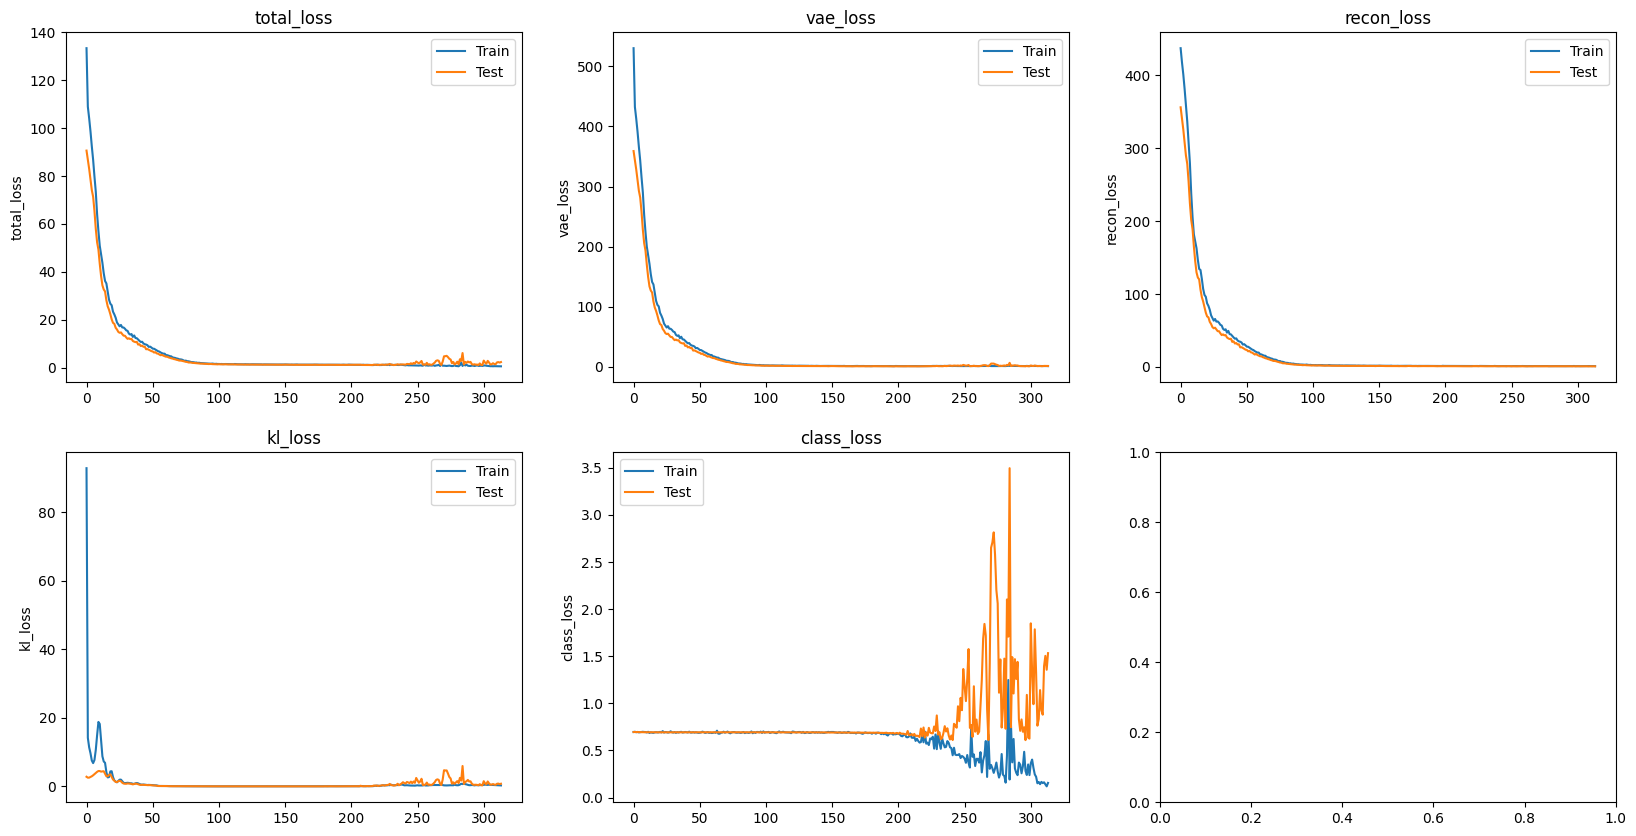

In [90]:
## Plot the trainig losses
train_losses = loss_dict['train']
test_losses = loss_dict['test']
train_losses = pd.DataFrame(train_losses)
test_losses = pd.DataFrame(test_losses)

## Plot all losses in subplots
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
for i,c in enumerate(train_losses.columns):
    sns.lineplot(data=train_losses[c], ax=ax[i//3, i%3], label='Train')
    sns.lineplot(data=test_losses[c], ax=ax[i//3, i%3], label='Test')
    ax[i//3, i%3].set_title(c)



In [91]:
## Save the model
torch.save(model.state_dict(), '../Dataset/Saved_models/DTI_autoencoder.pth')

## Visualization

In [92]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = DTI_autoencoder(num_classes=1, latent_dim=32)
model.load_state_dict(torch.load('../Dataset/Saved_models/DTI_autoencoder.pth')) 
model = model.to(device)

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


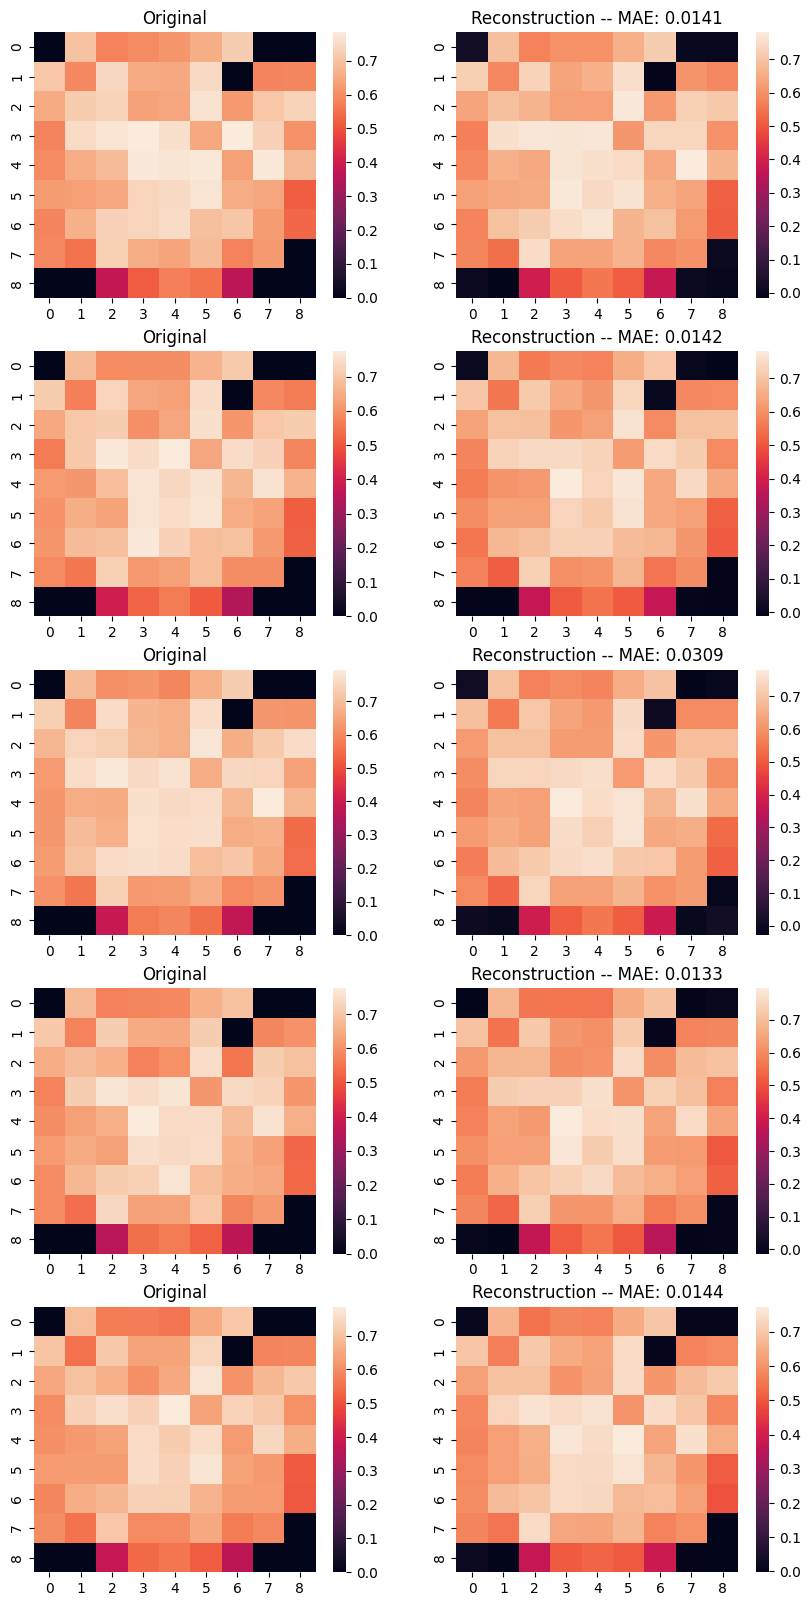

In [93]:
## Get the prediction on Y_test
x_recon, y_pred, mu, logvar = model(torch.tensor(X_test, dtype=torch.float32).to(device))

## Make a color plot of x_recon and X_test for 5 samples
fig, ax = plt.subplots(5, 2, figsize=(10, 20))
for i in range(5):
    sns.heatmap(X_test[i][0].cpu().detach().numpy(), ax=ax[i, 0])
    sns.heatmap(x_recon[i].cpu().detach().numpy().squeeze(), ax=ax[i, 1])

    ## Calculate mean absolute error
    mae = np.abs(X_test[i][0].cpu().detach().numpy() - x_recon[i].cpu().detach().numpy().squeeze()).mean()
    ## Add this to the title as a super title
    ax[i, 0].set_title("Original")
    ax[i, 1].set_title(f'Reconstruction -- MAE: %1.4f' % mae)
    
plt.show()

In [95]:
## Calculate reconstruction loss on test
recon_loss = np.abs(X_test.cpu().detach().numpy() - x_recon.cpu().detach().numpy()).mean(axis=(1, 2, 3))
recon_loss = pd.DataFrame(recon_loss, columns=['Reconstruction Loss'])
recon_loss['Subject'] = master_sheet['Subject'][test_idx].values

recon_loss['Reconstruction Loss'].mean()

0.017191501

## Checking the Latent Space

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


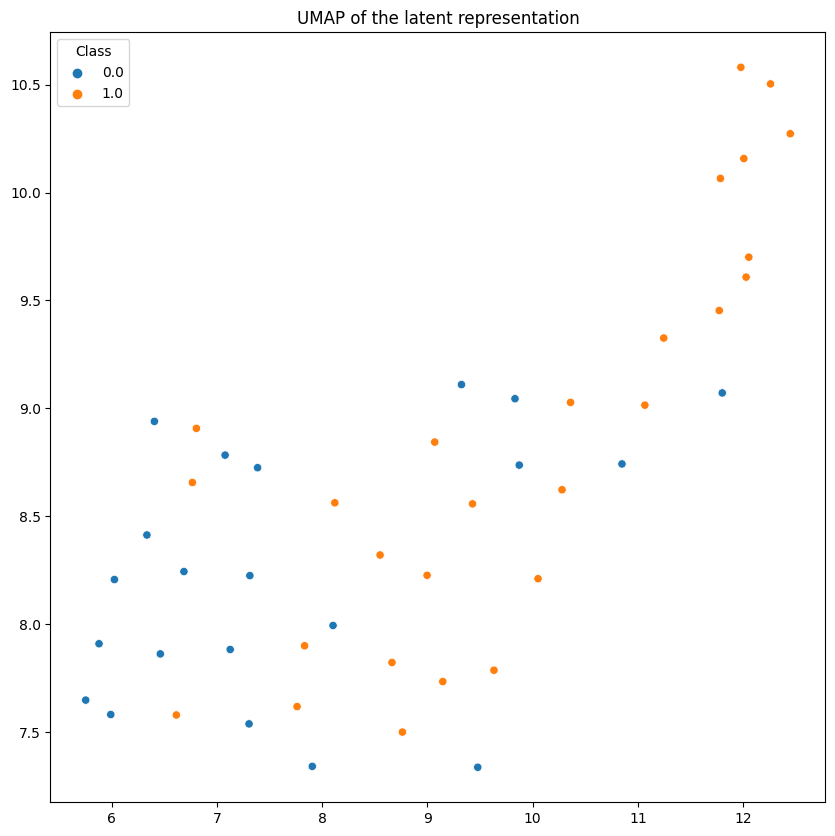

0.8333333333333334

In [60]:
## Get a latent encoding of the test data
_, _, mu, logvar = model(torch.tensor(X_test, dtype=torch.float32).to(device))
## Get reparepresentation of the test data
mu = mu.cpu().detach().numpy()

## Plot z with UMAP clustering
reducer = umap.UMAP()
z_umap = reducer.fit_transform(mu)
## Scatter Plot with Legend
plt.figure(figsize=(10, 10))
sns.scatterplot(x=z_umap[:, 0], y=z_umap[:, 1], hue=Y_test.cpu().detach().numpy())
plt.legend(title='Class')
plt.title('UMAP of the latent representation')
plt.show()

## Get teh KNN accuracy of the latent representation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(mu, Y_test.cpu().detach().numpy())
y_pred = knn.predict(mu)
accuracy_score(Y_test.cpu().detach().numpy(), y_pred)


### XAI test on the latent vector

In [202]:
from sklearn.decomposition import PCA

In [203]:
## Encode the entire X_test
model.eval()
with torch.no_grad():
    x_recon, y_pred, mu, logvar = model(torch.tensor(X_test, dtype=torch.float32).to(device))
    ## Get the encoder's z
    z = model.reparameterize(mu, logvar)
    

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [204]:
## Making explanability class
class Exp_Model:
    def __init__(self, model, tract):
        self.model = model
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.model.eval()
        self.model.to(self.device)
        self.tract = tract
        self.dti_representation = np.load('../Dataset/NEUROFIT_diffusion/aggregated_grid.npy', allow_pickle=True)

    def predict(self, embedding):
        '''
        Predict the decoder output for an embedding for a particular tract
        '''
        ## Change embedding to tensor if not tensor
        if not torch.is_tensor(embedding):
            embedding = torch.tensor(embedding, dtype=torch.float32).to(self.device)

        output = model.decode(embedding)
        
        ## In dti representation, find the index of the tract name
        tract_index = [i[0] for i in np.where(self.dti_representation==self.tract)]
        tract_output =  output[:,0,tract_index[0], tract_index[1]]

        ## Convert to numpy and return
        return tract_output.cpu().detach().numpy()
        

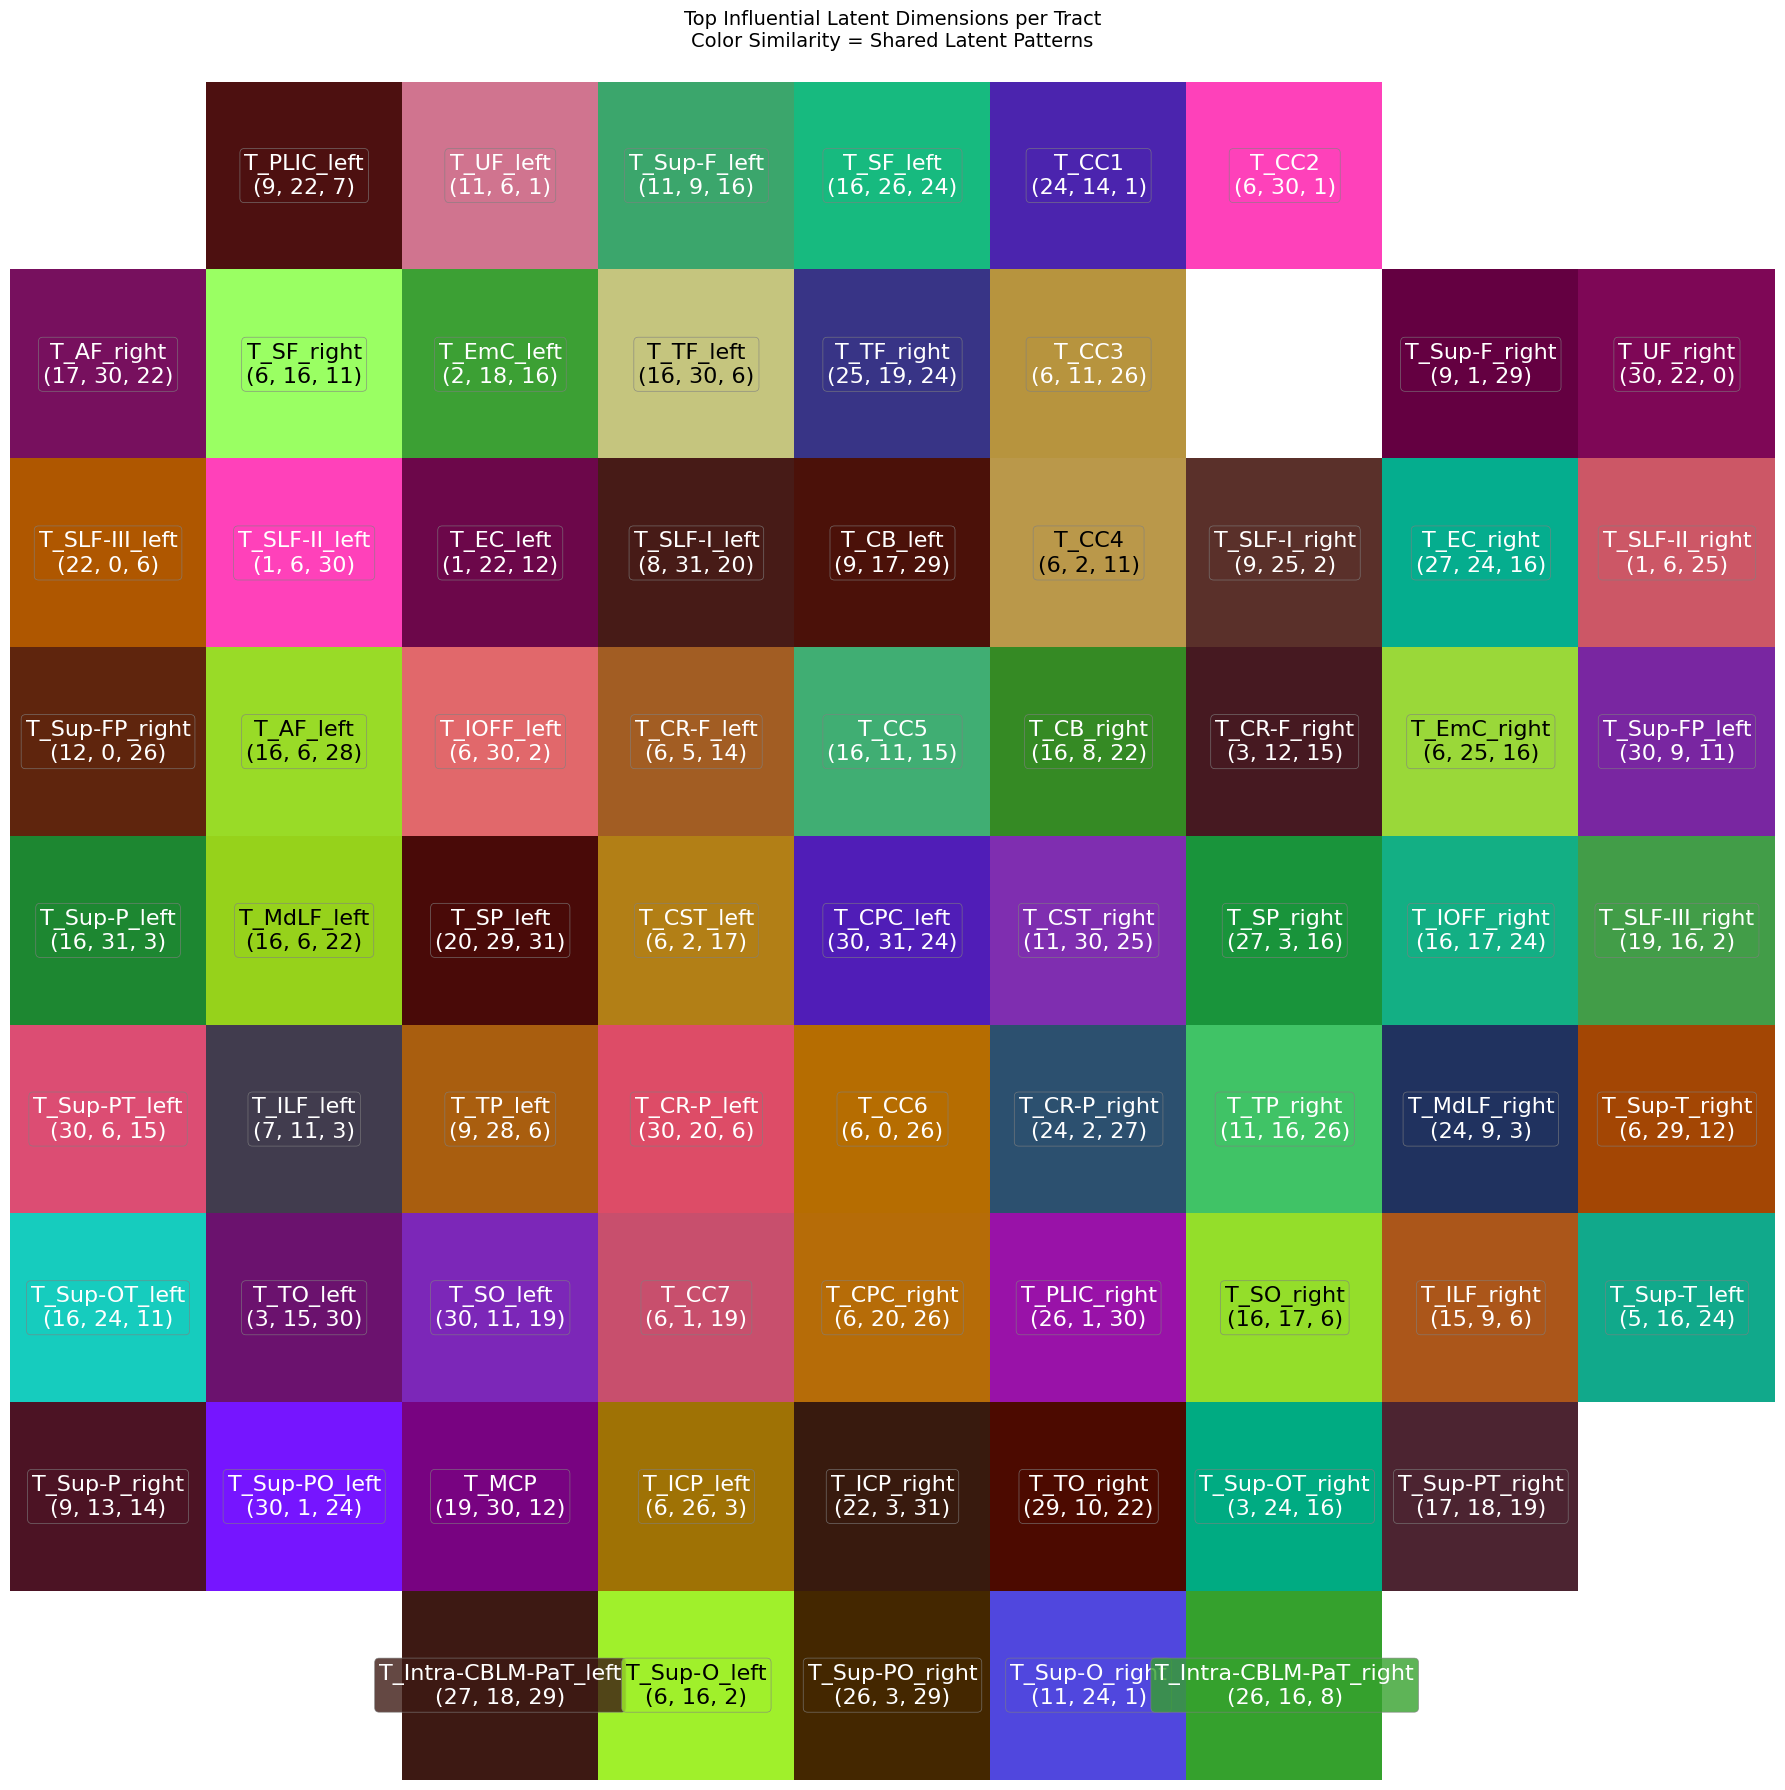

In [205]:
# ... [Keep all previous imports and device setup] ...

# =============================================
# Improved SHAP Explanation with Color Coding
# =============================================

def compute_tract_similarity(top_vectors):
    """Compute Jaccard similarity between tract vectors"""
    tracts = list(top_vectors.keys())
    similarity = np.zeros((len(tracts), len(tracts)))
    
    for i, t1 in enumerate(tracts):
        for j, t2 in enumerate(tracts):
            set1 = set(top_vectors[t1])
            set2 = set(top_vectors[t2])
            similarity[i,j] = len(set1 & set2)/len(set1 | set2)
            
    return similarity, tracts

# Create common background for all explainers
background = z[np.random.choice(len(z), 100, replace=True)].cpu().detach().numpy()

top_vectors = {}
tract_list = list(set(dti_representation.reshape(-1)) - {''})

# First pass: Compute all SHAP values
for tract in tract_list:
    explanability_model = Exp_Model(model, tract)
    
    # Create explainer with proper background
    explainer = shap.Explainer(
        explanability_model.predict, 
        background, 
        algorithm='auto'
    )
    
    # Compute SHAP values
    shap_values = explainer(z.cpu().detach().numpy())
    
    # Store top 3 vectors (using absolute values for magnitude)
    mean_vals = np.abs(shap_values.values).mean(axis=0)
    top_vectors[tract] = mean_vals.argsort()[-3:][::-1]

# =============================================
# Enhanced Visualization with Color Coding
# =============================================

# Compute similarity matrix
similarity, tracts = compute_tract_similarity(top_vectors)

# Reduce to 3D color space using PCA
pca = PCA(n_components=3)
colors = pca.fit_transform(similarity)
colors = (colors - colors.min(0)) / (colors.max(0) - colors.min(0))  # Normalize 0-1

# Create color map and text matrix
tract_to_color = {tract: colors[i] for i, tract in enumerate(tracts)}
cell_text = np.empty_like(dti_representation, dtype=object)
cell_colors = np.ones((*dti_representation.shape, 3))  # White background

for i in range(dti_representation.shape[0]):
    for j in range(dti_representation.shape[1]):
        tract = dti_representation[i,j]
        if tract != '':
            # Format text with top vectors
            vectors = ', '.join(map(str, top_vectors[tract]))
            cell_text[i,j] = f"{tract}\n({vectors})"
            
            # Assign color from PCA projection
            cell_colors[i,j] = tract_to_color[tract]

# Create plot with improved styling
plt.figure(figsize=(18, 18))
ax = plt.gca()

# Create colored background
ax.imshow(cell_colors, interpolation='nearest', aspect='auto')

# Add text with automatic color contrast
for (i,j), val in np.ndenumerate(cell_text):
    if val is not None:
        # Calculate background brightness
        bg_brightness = 0.299 * cell_colors[i,j,0] + 0.587 * cell_colors[i,j,1] + 0.114 * cell_colors[i,j,2]
        text_color = 'black' if bg_brightness > 0.6 else 'white'
        
        ax.text(j, i, val, 
               ha='center', va='center', 
               fontsize=16, 
               color=text_color,
               bbox=dict(
                   boxstyle='round,pad=0.2',
                   facecolor=cell_colors[i,j],
                   edgecolor='grey',
                   linewidth=0.5,
                   alpha=0.8
               ))

# Grid formatting
ax.set_xticks(np.arange(-.5, dti_representation.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-.5, dti_representation.shape[0], 1), minor=True)
ax.grid(which='minor', color='white', linestyle='-', linewidth=1)
ax.tick_params(which='both', length=0)
## Remove axis
plt.axis('off')

plt.title("Top Influential Latent Dimensions per Tract\nColor Similarity = Shared Latent Patterns", pad=25, fontsize=14)
plt.tight_layout()
plt.show()

## MIG Calculation

In [206]:
from sklearn.metrics import mutual_info_score

In [ ]:
frontal_grid = np.array([
    ['', 'T_Sup-F_left', 'T_SF_left', 'T_AF_left', 'T_TF_left', '', '', '', ''],
    ['', 'T_SF_right', 'T_Sup-F_right', 'T_AF_right', 'T_TF_right', 'T_Sup-FP_right', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', '']
], dtype=object)

# Temporal region factor
temporal_grid = np.array([
    ['', 'T_UF_left', 'T_ILF_left', 'T_TP_left', 'T_TO_left', 'T_SO_left', 'T_EC_left', '', ''],
    ['', 'T_UF_right', 'T_ILF_right', 'T_TP_right', 'T_SO_right', 'T_EC_right', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', '']
], dtype=object)

# Parietal region factor
parietal_grid = np.array([
    ['T_SLF-III_left', 'T_SLF-II_left', 'T_SLF-I_left', 'T_SP_left', 'T_MdLF_left', '', '', '', ''],
    ['T_SLF-III_right', 'T_SLF-II_right', 'T_SLF-I_right', 'T_SP_right', 'T_MdLF_right', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', '']
], dtype=object)

# Occipital region factor
occipital_grid = np.array([
    ['', 'T_IOFF_left', 'T_Sup-OT_left', '', '', '', '', '', ''],
    ['', 'T_IOFF_right', 'T_Sup-OT_right', 'T_Sup-O_right', 'T_Sup-PO_right', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', '']
], dtype=object)

# Projection/Subcortical region factor
projection_grid = np.array([
    ['T_PLIC_left', 'T_CST_left', 'T_CB_left', 'T_CR-F_left', 'T_CR-P_left', '', '', '', ''],
    ['T_PLIC_right', 'T_CST_right', 'T_CB_right', 'T_CR-F_right', 'T_CR-P_right', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', '']
], dtype=object)

# Cerebellar region factor
cerebellar_grid = np.array([
    ['T_Intra-CBLM-PaT_left', '', '', '', '', '', '', '', ''],
    ['T_CPC_left', 'T_CPC_right', 'T_MCP', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', '']
], dtype=object)

# Corpus Callosum factor (if desired)
cc_grid = np.array([
    ['', '', 'T_CC1', 'T_CC2', '', '', '', '', ''],
    ['', 'T_CC3', '', '', '', '', '', '', ''],
    ['', '', 'T_CC4', '', '', '', '', '', ''],
    ['', '', 'T_CC5', '', '', '', '', '', ''],
    ['', '', 'T_CC6', '', '', '', '', '', ''],
    ['', '', 'T_CC7', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', '']
], dtype=object)

# Combine all region factors into a list (or dict for labeled access)
test_grids = [frontal_grid,
               temporal_grid, 
               parietal_grid, 
               occipital_grid, 
               projection_grid, 
               cerebellar_grid]

In [216]:
# Create mapping between tracts and their grid positions
tract_positions = {}
for i in range(9):
    for j in range(9):
        tract = dti_representation[i, j]
        if tract.strip():
            tract_positions[tract] = (i, j)

tract_list = list(tract_positions.keys())

def create_factor_matrix(sample_grids):
    """Convert list of 9x9 grids to binary factor matrix"""
    n_samples = len(sample_grids)
    factor_matrix = np.zeros((n_samples, len(tract_list)), dtype=int)
    
    for idx, grid in enumerate(sample_grids):
        for tract_idx, tract in enumerate(tract_list):
            i, j = tract_positions[tract]
            factor_matrix[idx, tract_idx] = int(grid[i, j].strip() != '')
            
    return factor_matrix


def compute_tract_mig(model, X_test, tract_factors):
    """Compute MIG specifically for tract presence factors"""
    model.eval()
    device = next(model.parameters()).device
    
    # Get latent representations
    with torch.no_grad():
        X_test = X_test.float().to(device)
        mu, _ = model.encode(X_test)
    latents = mu.cpu().numpy()
    
    # Compute Mutual Information Gap
    n_factors = tract_factors.shape[1]
    latent_dim = latents.shape[1]
    mig_scores = []
    
    for tract_idx in range(n_factors):
        factor = tract_factors[:, tract_idx]
        mi_scores = []
        
        for latent_dim in range(latent_dim):
            mi = mutual_info_score(factor, latents[:, latent_dim])
            mi_scores.append(mi)
            
        sorted_mi = np.sort(mi_scores)[::-1]
        mig = (sorted_mi[0] - sorted_mi[1]) / np.log(2)  # Binary factors
        mig_scores.append(mig)
    
    return {
        'mean_mig': np.mean(mig_scores),
        'tract_migs': mig_scores,
        'tract_names': tract_list
    }

ground_truth_factors = create_factor_matrix(test_grids)


In [217]:
import numpy as np

# Generate 48 synthetic samples that match your real X_test size
n_samples = 48  # Should match len(X_test)
test_grids = []

for _ in range(n_samples):
    # Create a blank 9x9 grid
    grid = np.full((9, 9), '', dtype=object)
    
    # Randomly activate 5-15 tracts per sample
    n_tracts = np.random.randint(5, 15)
    for _ in range(n_tracts):
        i, j = np.random.randint(0, 9, 2)
        tract = dti_representation[i, j]
        if tract.strip():  # Only populate valid tract positions
            grid[i, j] = tract
    
    test_grids.append(grid)

# Verify shape
def create_factor_matrix(sample_grids):
    """Convert list of 9x9 grids to binary factor matrix"""
    tract_positions = {}
    for i in range(9):
        for j in range(9):
            tract = dti_representation[i, j]
            if tract.strip():
                tract_positions[tract] = (i, j)
    
    tract_list = list(tract_positions.keys())
    factor_matrix = np.zeros((len(sample_grids), len(tract_list)), dtype=int)
    
    for idx, grid in enumerate(sample_grids):
        for tract_idx, tract in enumerate(tract_list):
            i, j = tract_positions[tract]
            factor_matrix[idx, tract_idx] = int(grid[i, j].strip() != '')
            
    return factor_matrix

ground_truth_factors = create_factor_matrix(test_grids)
print("Factor matrix shape:", ground_truth_factors.shape)  # Should be (48, N_tracts)

Factor matrix shape: (48, 72)


In [218]:
import numpy as np
from sklearn.metrics import mutual_info_score

def compute_individual_tract_mig(model, X_test, tract_factors, tract_names, n_bins=20):
    """
    Compute MIG for each tract individually and identify best latent dimension
    
    Args:
        model: Trained VAE model
        X_test: Input images (shape [N, 9, 9])
        tract_factors: Binary matrix of tract presence (shape [N, num_tracts])
        tract_names: List of tract names corresponding to tract_factors columns
        n_bins: Number of bins for discretizing latent dimensions
        
    Returns:
        Dictionary with MIG scores and latent associations for each tract
    """
    model.eval()
    device = next(model.parameters()).device
    
    # Get latent representations
    with torch.no_grad():
        X_test = X_test.float().to(device)  # Add channel dimension
        mu, _ = model.encode(X_test)
    latents = mu.cpu().numpy()
    
    # Discretize latent dimensions
    latents_discrete = np.zeros_like(latents)
    for i in range(latents.shape[1]):
        latents_discrete[:, i] = np.digitize(latents[:, i], 
                                           np.linspace(latents[:, i].min(), 
                                                       latents[:, i].max(), 
                                                       n_bins))
    
    # Calculate entropy for each tract
    tract_entropy = []
    for k in range(tract_factors.shape[1]):
        p = np.mean(tract_factors[:, k])
        if p == 0 or p == 1:
            tract_entropy.append(0)
        else:
            tract_entropy.append(-p * np.log(p) - (1-p) * np.log(1-p))
    
    results = {}
    
    # Calculate MIG for each tract
    for tract_idx in range(tract_factors.shape[1]):
        tract = tract_names[tract_idx]
        factor = tract_factors[:, tract_idx]
        H = tract_entropy[tract_idx]
        
        if H == 0:
            # Skip tracts that are always present or absent
            results[tract] = {
                'mig': 0,
                'best_latent': None,
                'top_mi_scores': [],
                'entropy': 0
            }
            continue
            
        mi_scores = []
        for dim in range(latents_discrete.shape[1]):
            mi = mutual_info_score(factor, latents_discrete[:, dim])
            mi_scores.append((mi, dim))
            
        # Sort MI scores descending
        mi_scores.sort(reverse=True, key=lambda x: x[0])
        
        if len(mi_scores) < 2:
            mig = 0
        else:
            mig = (mi_scores[0][0] - mi_scores[1][0]) / H
            
        results[tract] = {
            'mig': mig,
            'best_latent': mi_scores[0][1],
            'top_mi_scores': mi_scores[:5],  # Top 5 latent dimensions
            'entropy': H
        }
    
    return results

# Usage example
tract_names = [t for row in dti_representation for t in row if t.strip()]  # Your tract names
results = compute_individual_tract_mig(model, X_test, ground_truth_factors, tract_names)

# Print results sorted by MIG
sorted_results = sorted(results.items(), key=lambda x: -x[1]['mig'])

print("Mean MIG Score:", np.mean([info['mig'] for info in results.values()]))
print("Tract-wise MIG Scores:")
for tract, info in sorted_results:
    if info['entropy'] == 0:
        continue  # Skip constant tracts
    print(f"{tract}:")
    print(f"  MIG: {info['mig']:.3f}")
    print(f"  Best latent: {info['best_latent']}")
    print(f"  Top MI scores: {[f'Latent {dim}: {score:.3f}' for score, dim in info['top_mi_scores']]} ")
    print("-------------------")

Mean MIG Score: 0.06200735212832853
Tract-wise MIG Scores:
T_ICP_left:
  MIG: 0.264
  Best latent: 4
  Top MI scores: ['Latent 4: 0.247', 'Latent 12: 0.171', 'Latent 26: 0.164', 'Latent 27: 0.158', 'Latent 11: 0.153'] 
-------------------
T_MdLF_left:
  MIG: 0.201
  Best latent: 13
  Top MI scores: ['Latent 13: 0.231', 'Latent 5: 0.173', 'Latent 21: 0.169', 'Latent 30: 0.160', 'Latent 6: 0.160'] 
-------------------
T_MCP:
  MIG: 0.200
  Best latent: 29
  Top MI scores: ['Latent 29: 0.205', 'Latent 24: 0.158', 'Latent 28: 0.154', 'Latent 6: 0.142', 'Latent 17: 0.135'] 
-------------------
T_ILF_left:
  MIG: 0.181
  Best latent: 21
  Top MI scores: ['Latent 21: 0.282', 'Latent 12: 0.207', 'Latent 9: 0.204', 'Latent 14: 0.200', 'Latent 0: 0.195'] 
-------------------
T_SLF-I_right:
  MIG: 0.173
  Best latent: 4
  Top MI scores: ['Latent 4: 0.247', 'Latent 11: 0.190', 'Latent 27: 0.177', 'Latent 12: 0.173', 'Latent 6: 0.168'] 
-------------------
T_Sup-OT_right:
  MIG: 0.167
  Best latent

## XAI Classifier

In [49]:
class Exp_Model:
    def __init__(self, model):
        self.model = model
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.model.eval()
        self.model.to(self.device)

    def predict(self, x):
        '''
        Predict the decoder output for an embedding for a particular tract
        '''
        x = torch.tensor(x, dtype=torch.float32).to(self.device)
        x = x.view(-1,1,9,9)
        x_recon, y_pred, mu, logvar = self.model(x)
        return torch.sigmoid(y_pred).detach().cpu().numpy()


In [88]:
class Exp_Model2:
    def __init__(self, model, classifier):
        self.model = model
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.model.eval()
        self.model.to(self.device)
        self.classifier = classifier

    def predict(self, x):
        '''
        Predict the decoder output for an embedding for a particular tract
        '''
        x = torch.tensor(x, dtype=torch.float32).to(self.device)
        x = x.view(-1,1,9,9)
        x_recon, y_pred, mu, logvar = self.model(x)
        mu = mu.cpu().detach().numpy()
        pred = self.classifier.predict(mu)
        return pred

In [ ]:
## Repeated KFold test
from sklearn.model_selection import RepeatedKFold
from lazypredict.supervised import LazyClassifier
from sklearn.ensemble import RandomForestClassifier
rkf = RepeatedKFold(n_splits=10, n_repeats=1, random_state=42)
shap_results = []
device = torch.device('cuda')
for train_index, test_index in tqdm(rkf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(Y_train, dtype=torch.float32))
    test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(Y_test, dtype=torch.float32))

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


    backbone = DTI_autoencoder(num_classes=1, latent_dim=32)
    optimizer = torch.optim.Adam(backbone.parameters(), lr=0.001)
    criterion = torch.nn.BCEWithLogitsLoss()
    model,_,loss_dict = train_model(train_loader,
                    test_loader, 
                    model=backbone,
                    optimizer=optimizer,
                    n_epochs=1000,
                    batch_size=16,
                    verbose=False)
    
    ## Extract the latent vectors for X_test 
    _, _, mu, logvar = model(torch.tensor(X_test, dtype=torch.float32).to(device))
    ## Get reparepresentation of the test data
    mu_test = mu.cpu().detach().numpy()

    ## Get the latent vectors for X_train
    _, _, mu, logvar = model(torch.tensor(X_train, dtype=torch.float32).to(device))
    ## Get reparepresentation of the train data
    mu_train = mu.cpu().detach().numpy()

    dtm = RandomForestClassifier()
    dtm.fit(mu_train, Y_train)

    print("Mean Accuracy: ", accuracy_score(Y_test, dtm.predict(mu_test)))
    print("Mean F1: ", f1_score(Y_test, dtm.predict(mu_test)))
        
    
    exp_model = Exp_Model2(model, dtm)
    explainer = shap.Explainer(exp_model.predict, test_loader.dataset.tensors[0].cpu().detach().numpy().reshape(-1,81))
    shap_values = explainer(test_loader.dataset.tensors[0].cpu().detach().numpy().reshape(-1,81))

    # explainer = shap.Explainer(dtm.predict, mu_test)
    # shap_values = explainer(mu_test)

    shap_results.append(shap_values)




In [99]:
merged_values = np.concatenate([ex.values for ex in shap_results], axis=0)
merged_base_values = np.concatenate([ex.base_values for ex in shap_results], axis=0)
merged_data = np.concatenate([ex.data for ex in shap_results], axis=0)

# Create a new Explanation object.
merged_explanation = shap.Explanation(
    values=merged_values,
    base_values=merged_base_values,
    data=merged_data,
    feature_names=shap_results[0].feature_names
)

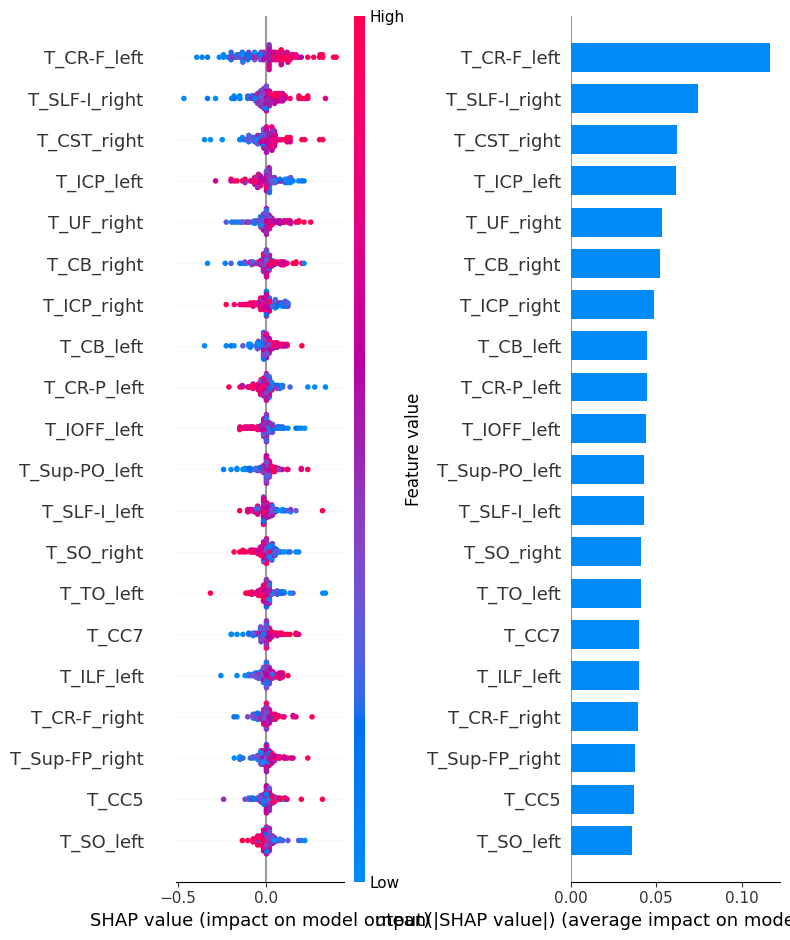

In [102]:
tract_names = dti_representation.reshape(-1)

## Make subplots for shap
plt.figure(figsize=(30, 5))
plt.subplot(1, 2, 1)
shap.summary_plot(merged_explanation, feature_names=tract_names,show=False)
plt.subplot(1, 2, 2)
shap.summary_plot(merged_explanation, feature_names=tract_names, plot_type='bar', show=False)
plt.show()